In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import utm

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, mean_squared_error, classification_report

import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Input, Activation, concatenate
from keras.callbacks import History
from keras.models import Model

# The values have around 15 decimals, so for more clarity in reading we're increasing the number of displayed values
pd.set_option('display.float_format', '{:.15f}'.format)

# 1. Importing the data

In [222]:
sensor_and_loc_file = '../data/Processed/full_sensor_data_no_interpol_and_location.csv'

In [223]:
df_sensor_and_loc = pd.read_csv(sensor_and_loc_file, index_col=0)
df_sensor_and_loc

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:61,0.412078860000000,0.443542480000000,9.409470000000001,0.032653810000000,0.321075440000000,-0.377655030000000,NaN,NaN,NaN,9.428927012090160,0.496768589146909,NaN,NaN,NaN
12:15:51:62,0.378555300000000,0.465087900000000,9.435805999999999,0.018798828000000,0.324279800000000,-0.366989140000000,NaN,NaN,NaN,9.454842449217251,0.490093678290338,NaN,NaN,NaN
12:15:51:63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12:15:51:64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19:09:27:16,1.302719100000000,0.520156860000000,7.142166000000000,-0.118621826000000,-0.505569460000000,0.092132570000000,NaN,NaN,NaN,7.278610814164050,0.527408785424618,NaN,NaN,NaN
19:09:27:17,2.049713100000000,0.280731200000000,8.202788999999999,-0.301849370000000,-0.332992550000000,0.140075680000000,23.100280000000001,-16.200256000000000,-262.800599999999974,8.459662001373697,0.470763503951147,264.310852200404213,NaN,NaN
19:09:27:18,2.140686000000000,0.043701172000000,9.170044000000001,-0.590530400000000,0.304031370000000,0.046325684000000,23.100280000000001,-13.949585000000001,-261.749270000000024,9.416695455676912,0.665813259304968,263.136645496752351,NaN,NaN
19:09:27:19,1.896484400000000,-0.226837160000000,9.799728000000000,-0.686401370000000,0.651306150000000,-0.067657470000000,NaN,NaN,NaN,9.984126253738191,0.948643281224560,NaN,NaN,NaN


In [224]:
df_sensor_and_loc.loc[:, 'lat'].interpolate(method='linear', inplace=True)
df_sensor_and_loc.loc[:, 'long'].interpolate(method='linear', inplace=True)
df_sensor_and_loc.dropna(inplace=True)
df_sensor_and_loc.shape

(31074, 14)

## 1.1. Creating x and y

In [225]:
# df_sensor_and_loc['x'] = np.nan
# df_sensor_and_loc['y'] = np.nan
# for i in range(len(df_sensor_and_loc)):
#     lat = df_sensor_and_loc['lat'].iloc[i]
#     long = df_sensor_and_loc['long'].iloc[i]
#     df_sensor_and_loc['x'].iloc[i], df_sensor_and_loc['y'].iloc[i], zone, ut = utm.from_latlon(df_sensor_and_loc['lat'].iloc[i], df_sensor_and_loc['long'].iloc[i])
# df_sensor_and_loc

In [226]:
# plt.scatter(x=df_sensor_and_loc['x'], y=df_sensor_and_loc['y'])

In [253]:
data = df_sensor_and_loc.copy(deep=True)[::5]
# data = data[:len(data)//3, :]
print(data.shape)
data

(6215, 14)


,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:76,0.986679100000000,0.407623300000000,10.673614499999999,-0.573486300000000,0.265686040000000,-0.366989140000000,55.050660000000001,-50.250244000000002,-259.649659999999983,10.726869948670483,0.730860203470206,270.136276954078710,44.434937499999926,26.047602759473087
12:15:51:87,1.343414300000000,1.456283600000000,8.241104000000000,-0.245376590000000,-0.293579100000000,-0.097488400000000,55.650329999999997,-49.349975999999998,-260.699459999999988,8.475925851722007,0.394844712528100,271.102541125311234,44.434937499999876,26.047603625360832
12:15:51:96,1.092025800000000,1.726821900000000,9.117386000000000,-0.080261230000000,-0.214752200000000,-0.044219970000000,54.899597000000000,-48.899839999999998,-261.000060000000019,9.343509067538880,0.233486141329103,271.157134191213231,44.434937499999840,26.047604333814444
12:15:52:07,1.060897800000000,1.839355500000000,10.173218000000000,0.218002320000000,-0.320205700000000,0.119827270000000,55.650329999999997,-47.850037000000000,-261.300659999999993,10.392453861959124,0.405481536538380,271.412269778736913,44.434937499999791,26.047605199702190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19:09:26:72,0.139129640000000,1.252777100000000,7.376800500000000,-0.182525630000000,-0.282928470000000,-0.038894653000000,25.199890000000000,-11.549377000000000,-257.099899999999991,7.483715196064798,0.338934977208650,258.589986552283619,44.434937499964839,26.047606537809013
19:09:26:82,0.342636100000000,2.478607200000000,10.170821999999999,-0.200637820000000,-0.820877100000000,-0.094284060000000,22.950745000000001,-10.049438000000000,-255.599979999999988,10.474087707509376,0.850284794694605,256.824994259069854,44.434937499964782,26.047605488248109
19:09:26:92,0.433624270000000,1.417984000000000,10.498840000000000,0.427856450000000,0.043045044000000,0.896408100000000,21.600342000000001,-8.700562000000000,-257.249450000000024,10.603034941816849,0.994214010847350,258.301285476738030,44.434937499964725,26.047604438687202
19:09:27:02,4.103927600000000,0.304672240000000,12.253784000000000,-0.113296510000000,0.816421500000000,-0.112396240000000,20.100403000000000,-8.999634000000000,-258.000180000000000,12.926340133174756,0.831873235298845,258.938433788668704,44.434937499964668,26.047603389126298


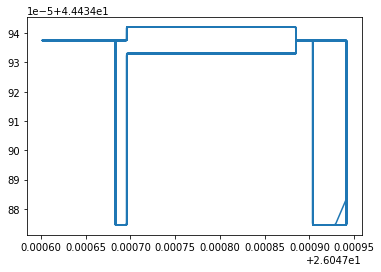

In [254]:
plt.plot(data['long'], data['lat'])

In [255]:
# plt.plot(data['x'], data['y'])

# 2. Creating the LSTM model

## 2.1. Scaling the data

In [256]:
backcandles=100

sc_attributes = MinMaxScaler(feature_range=(-1, 1))
attributes_scaled = sc_attributes.fit_transform(data.iloc[:, :-2])

sc_targets = MinMaxScaler(feature_range=(0, 1))
targets_scaled = sc_targets.fit_transform(data.iloc[backcandles:, [-2, -1]])
# y_test_1 = data.iloc[:, [-2, -1]]
# print(y_test_1)
# y_test_sc = sc.fit_transform(data.iloc[:, [-2, -1]])
# print(data_scaled)

In [257]:
print(attributes_scaled.shape[0], attributes_scaled.shape[1], targets_scaled.shape)

6215 12 (6115, 2)


## 2.2. Principal Component Analysis (PCA)

In [258]:
# pca = PCA(n_components=3)

In [259]:
# pca.fit_transform(attributes_scaled)

## 2.2. Reshaping the data in order to feed it to the model

In [260]:
# The following cell does this:

# []
# i = 0
# X = [[]]
# for j in range(30, 8611)
#     J = 30
#     X[0].append(data_scaled[30-30=0:30, 0]) --> append and array
#     J = 31
#     X[0].append(31-30=1:31, 0)
#     
# i = 1
# X = [
#       [  <-- 12 of those
#        [5.5811, 5.4786, .., 5.1232  <--- 30 (backcandles) of those], [], ..., [] <--- 8581 of those
#       ],
#      [
#        [5.5811, 5.4786, .., 5.1232], [], ..., []
#      ]
#    ]   ---> 
# for j in range(30, 8611)
#     X[0].append(data_scaled[30-30:30, 0])

In [261]:
X = []
backcandles=backcandles # number of last values to look into

for i in range(12): #number of attributes columns
    X.append([])
    for j in range(backcandles, attributes_scaled.shape[0]):
        X[i].append(attributes_scaled[j-backcandles:j, i])
        
# move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

# We need shape (8581, 30, 12) = (rows, val of past attributes, columns) for LSTM training
X.shape

(6115, 100, 12)

In [262]:
# Transform X and the targets (lat and long columns) into arrays so the axis can be moved and the data 
# to be used in the LSTM model
X, y = np.array(X), np.array(targets_scaled)

# Move the axis for yi, so instead of (8581, 2) we'll have (8581, 1, 2)
# I HAVE MODIFIED THIS:
# y = np.reshape(yi,(len(yi), 1, 2))
# y = np.reshape(yi,(len(yi), 2))

print('X Shape: ',X.shape)
print('y shape: ', y.shape)
targets_scaled

X Shape:  (6115, 100, 12)
y shape:  (6115, 2)


array([[0.86857167, 0.24055327],
       [0.86222246, 0.24055327],
       [0.85587326, 0.24055327],
       ...,
       [0.93333312, 0.00839689],
       [0.93333312, 0.00530971],
       [0.93333312, 0.00222253]])

## 2.3. Split the data into train, test and validation sets

In [263]:
splitlimit_test = int(len(X) * 0.7)
splitlimit_val = int(len(X) * 0.9)

print(splitlimit_test, splitlimit_val)
X_train, X_test, X_val = X[:splitlimit_test], X[splitlimit_test:splitlimit_val], X[splitlimit_val:]
y_train, y_test, y_val = y[:splitlimit_test], y[splitlimit_test:splitlimit_val], y[splitlimit_val:]
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

4280 5503
(4280, 100, 12)
(1223, 100, 12)
(612, 100, 12)
(4280, 2)
(1223, 2)
(612, 2)


## 2.4. Creating the LSTM  model

### 2.4.1. Create function to plot the training

In [264]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

### 2.4.2. Parametrizing the model

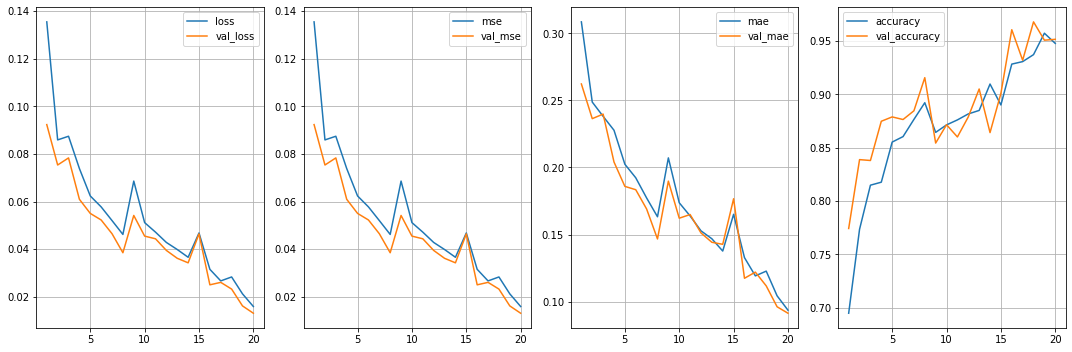

43/43 [==============================] - 8s 185ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0937 - accuracy: 0.9479 - val_loss: 0.0131 - val_mse: 0.0131 - val_mae: 0.0914 - val_accuracy: 0.9518
Epoch 21/50
22/43 [==============>...............] - ETA: 3s - loss: 0.0182 - mse: 0.0182 - mae: 0.0982 - accuracy: 0.9241

In [ ]:
attributes_cols = 12
batch_size=100
epochs=50

lstm_input = Input(shape=(backcandles, attributes_cols), name='lstm_input')
inputs = LSTM(128, name='first_layer', return_sequences=False)(lstm_input)
# inputs = LSTM(64, activation='relu', name='second_layer', return_sequences=False)(inputs)
inputs = Dense(2, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()

model.compile(optimizer=adam, loss='mse', metrics=['mse', 'mae', 'accuracy'])
model.fit(x=X_train, 
          y=y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          shuffle=False, 
          validation_data=(X_test, y_test), 
          callbacks=[PlotLearning()])

# model = Sequential()
# model.add(LSTM(128, activation='relu', name='first_layer', return_sequences=True))
# model.add(LSTM(128, activation='relu', name='second_layer', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(2, name='dense_layer'))
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=epochs)

In [ ]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])
len(y_pred), len(y_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

In [ ]:
plt.scatter(y_test[:, 1], y_test[:, 0], color='black', label='Test')
plt.scatter(y_pred[:, 1], y_pred[:, 0], color='blue', label='Pred')

In [ ]:
y_test_normalized = sc_targets.inverse_transform(y_test)
y_pred_normalized = sc_targets.inverse_transform(y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_normalized, y_pred_normalized)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared
r2 = r2_score(y_test_normalized, y_pred_normalized)
print("R-squared:", r2)

plt.plot(y_test_normalized[:, 1], y_test_normalized[:, 0], color='black', label='Test')
plt.plot(y_pred_normalized[:, 1], y_pred_normalized[:, 0], color='blue', label='Pred')
print(y_test_normalized, y_pred_normalized)

In [ ]:
model.evaluate(X_test, y_test)